[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/sensioai/blog/blob/master/024_mlp_clasificacion/mlp_clasificacion.ipynb)

# El Perceptrón Multicapa - Clasificación

## El Perceptrón Multicapa

En el [post](https://sensioai.com/blog/023_mlp_backprop) anterior hemos introducido el modelo de `Perceptrón Multicapa`, o MLP, la arquitectura de red neuronal más básica basada en el [Perceptrón](https://sensioai.com/blog/012_perceptron1). Hemos visto cómo calcular la salida de un MLP de dos capas a partir de unas entradas y cómo encontrar los pesos óptimos para una tarea de regresión. En este post vamos a mejorar la implementación de nuestro MLP de dos capas para que sea capaz también de llevar a cabo tareas de clasificación.

![](https://www.researchgate.net/profile/Mohamed_Zahran6/publication/303875065/figure/fig4/AS:371118507610123@1465492955561/A-hypothetical-example-of-Multilayer-Perceptron-Network.png)

## Implementación

La mayoría del código que utilizaremos fue desarrollado para el `Perceptrón` y lo puedes encontrar en este [post](https://sensioai.com/blog/018_perceptron_final). Lo único que cambiaremos es la lógica del modelo, el resto de funcionalidad (funciones de pérdida, funciones de activación, etc, siguen siendo exactamente igual).

### Funciones de activación

Para la capa oculta de nuestro MLP utilizaremos una función de activación de tipo `relu`, de la cual necesitaremos su derivada.

In [29]:
#---------------------------------------------------------------------------------
# se utiliza para el manejo de rutas y directorios.
import os

# Calculo cientifico y vectorial para python
import numpy as np

# Librerias para graficar
from matplotlib import pyplot

# Modulo de optimización de scipy
from scipy import optimize
from scipy.io import loadmat
# le dice a matplotlib que incruste gráficos en el cuaderno
%matplotlib inline
import matplotlib.pyplot as plt
#Pandas
import pandas as pd

In [30]:
def displayData(X, example_width=None, figsize=(10, 10)):
    """
    Muestra datos 2D almacenados en X en una cuadrícula apropiada.
    """
    # Calcula filas, columnas
    if X.ndim == 2:
        m, n = X.shape
    elif X.ndim == 1:
        n = X.size
        m = 1
        X = X[None]  # Promocionar a una matriz bidimensional
    else:
        raise IndexError('La entrada X debe ser 1 o 2 dimensinal.')

    example_width = example_width or int(np.round(np.sqrt(n)))
    example_height = n / example_width

    # Calcula el numero de elementos a mostrar
    display_rows = int(np.floor(np.sqrt(m)))
    display_cols = int(np.ceil(m / display_rows))

    fig, ax_array = plt.subplots(display_rows, display_cols, figsize=figsize)
    fig.subplots_adjust(wspace=0.025, hspace=0.025)

    ax_array = [ax_array] if m == 1 else ax_array.ravel()

    for i, ax in enumerate(ax_array):
        ax.imshow(X[i].reshape(example_width, example_width, order='F'),
                  cmap='Greys', extent=[0, 1, 0, 1])
        ax.axis('off')

In [31]:
def relu(x):
  return np.maximum(0, x)

def reluPrime(x):
  return x > 0

En cuanto a las funciones de activación que utilizaremos a la salida del MLP, éstas son las que hemos introducido en posts anteriores:

- Lineal: usada para regresión (junto a la función de pérdida MSE).
- Sigmoid: usada para clasificación binaria (junto a la función de pérdida BCE).
- Softmax: usada para clasificación multiclase (junto a la función de pérdida crossentropy, CE).

In [32]:
def linear(x):
    return x

def sigmoid(x):
  return 1 / (1 + np.exp(-x))

def softmax(x):
    return np.exp(x) / np.exp(x).sum(axis=-1,keepdims=True)

### Funciones de pérdida

Como acabamos de comentar en la sección anterior, estas son las funciones de pérdida que hemos visto hasta ahora para las diferentes tareas.

In [33]:
# Mean Square Error -> usada para regresión (con activación lineal)
def mse(y, y_hat):
    return np.mean((y_hat - y.reshape(y_hat.shape))**2)

# Binary Cross Entropy -> usada para clasificación binaria (con sigmoid)
def bce(y, y_hat):
    return - np.mean(y.reshape(y_hat.shape)*np.log(y_hat) - (1 - y.reshape(y_hat.shape))*np.log(1 - y_hat))

# Cross Entropy (aplica softmax + cross entropy de manera estable) -> usada para clasificación multiclase
def crossentropy(y, y_hat):
    logits = y_hat[np.arange(len(y_hat)),y]
    entropy = - logits + np.log(np.sum(np.exp(y_hat),axis=-1))
    return entropy.mean()

Y sus derivadas

In [34]:
def grad_mse(y, y_hat):
    return y_hat - y.reshape(y_hat.shape)

def grad_bce(y, y_hat):
    return y_hat - y.reshape(y_hat.shape)

def grad_crossentropy(y, y_hat):
    answers = np.zeros_like(y_hat)
    answers[np.arange(len(y_hat)),y] = 1    
    return (- answers + softmax(y_hat)) / y_hat.shape[0]

### Implementación MLP

Ahora que ya tenemos definidas las diferentes funciones de activación y de pérdida que necesitamos, vamos a implementar nuestro MLP de dos capas capaz de llevar a cabo tanto tareas de regresión como de clasificación. Del mismo modo que ya hicimos con el `Perceptrón`, definiremos una clase base que servirá para la implementación de las clases particulares para cada caso.

In [35]:
# clase base MLP 

class MLP():
  def __init__(self, D_in, H, D_out, loss, grad_loss, activation):
    # pesos de la capa 1
    self.w1, self.b1 = np.random.normal(loc=0.0,
                                  scale=np.sqrt(2/(D_in+H)),
                                  size=(D_in, H)), np.zeros(H)
    # pesos de la capa 2
    self.w2, self.b2 = np.random.normal(loc=0.0,
                                  scale=np.sqrt(2/(H+D_out)),
                                  size=(H, D_out)), np.zeros(D_out)
    self.ws = []
    # función de pérdida y derivada
    self.loss = loss
    self.grad_loss = grad_loss
    # función de activación
    self.activation = activation

  def __call__(self, x):
    # salida de la capa 1
    self.h_pre = np.dot(x, self.w1) + self.b1
    self.h = relu(self.h_pre)
    # salida del MLP
    y_hat = np.dot(self.h, self.w2) + self.b2 
    return self.activation(y_hat)
    
  def fit(self, X, Y, epochs = 100, lr = 0.001, batch_size=None, verbose=True, log_each=1):
    batch_size = len(X) if batch_size == None else batch_size
    batches = len(X) // batch_size
    l = []
    for e in range(1,epochs+1):     
        # Mini-Batch Gradient Descent
        _l = []
        for b in range(batches):
            # batch de datos
            x = X[b*batch_size:(b+1)*batch_size]
            y = Y[b*batch_size:(b+1)*batch_size] 
            # salida del perceptrón
            y_pred = self(x) 
            # función de pérdida
            loss = self.loss(y, y_pred)
            _l.append(loss)        
            # Backprop 
            dldy = self.grad_loss(y, y_pred) 
            grad_w2 = np.dot(self.h.T, dldy)
            grad_b2 = dldy.mean(axis=0)
            dldh = np.dot(dldy, self.w2.T)*reluPrime(self.h_pre)      
            grad_w1 = np.dot(x.T, dldh)
            grad_b1 = dldh.mean(axis=0)
            # Update (GD)
            self.w1 = self.w1 - lr * grad_w1
            self.b1 = self.b1 - lr * grad_b1
            self.w2 = self.w2 - lr * grad_w2
            self.b2 = self.b2 - lr * grad_b2
        l.append(np.mean(_l))
        # guardamos pesos intermedios para visualización
        self.ws.append((
            self.w1.copy(),
            self.b1.copy(),
            self.w2.copy(),
            self.b2.copy()
        ))
        if verbose and not e % log_each:
            print(f'Epoch: {e}/{epochs}, Loss: {np.mean(l):.5f}')

  def predict(self, ws, x):
    w1, b1, w2, b2 = ws
    h = relu(np.dot(x, w1) + b1)
    y_hat = np.dot(h, w2) + b2
    return self.activation(y_hat)

In [36]:
# MLP para regresión
class MLPRegression(MLP):
    def __init__(self, D_in, H, D_out):
        super().__init__(D_in, H, D_out, mse, grad_mse, linear)

# MLP para clasificación binaria
class MLPBinaryClassification(MLP):
    def __init__(self, D_in, H, D_out):
        super().__init__(D_in, H, D_out, bce, grad_bce, sigmoid)

# MLP para clasificación multiclase
class MLPClassification(MLP):
    def __init__(self, D_in, H, D_out):
        super().__init__(D_in, H, D_out, crossentropy, grad_crossentropy, linear)

## Clasificación Multiclase

Por último vamos a ver cómo aplicar nuestro modelo para clasificación en multiples clases.

In [37]:
input_layer_size  = 400

# 10 etiquetas, de 1 a 10 (tomar en cuenta que se asigna "0" a la etiqueta 10)
num_labels = 10

#  datos de entrenamiento almacenados en los arreglos X, y
data = loadmat('ex3data1.mat')
X, y = data['X'], data['y'].ravel()
# establecer el dígito cero en 0, en lugar del 10 asignado a este conjunto de datos
# Esto se hace debido a que el conjunto de datos se utilizó en MATLAB donde no hay índice 0
y[y == 10] = 0
salidas = len(np.unique(y))
m, n = X.shape

In [38]:
model = MLPClassification(D_in=n, H=5, D_out=salidas)
epochs, lr = 1000, 0.8
model.fit(X, y, epochs, lr, batch_size=4899, log_each=500)

Epoch: 500/1000, Loss: 0.66419
Epoch: 1000/1000, Loss: 0.52544


In [39]:
def interpretar(data):
    listaMayor = []
    for value in data:
        mayor = 0
        for index in range( len(value) ):
            if( value[index] >= value[mayor]):
                mayor = index
        listaMayor.append(mayor)
    return listaMayor

In [42]:
XPrueba = X[4899:4999, :].copy()
peso = [model.w1, model.b1, model.w2, model.b2]
prediccion = model.predict(peso, XPrueba)
print('Precision del conjuto de entrenamiento: {:.2f}%'.format(np.mean(interpretar(prediccion) == y[4899:4999]) * 100))

Precision del conjuto de entrenamiento: 80.00%


El valor es:  8
[[ -5.68989759   4.98696523   7.84617261   3.89747235  -5.77177134
    5.63441758   5.16103341 -12.46601224  13.10691259   4.75939214]]


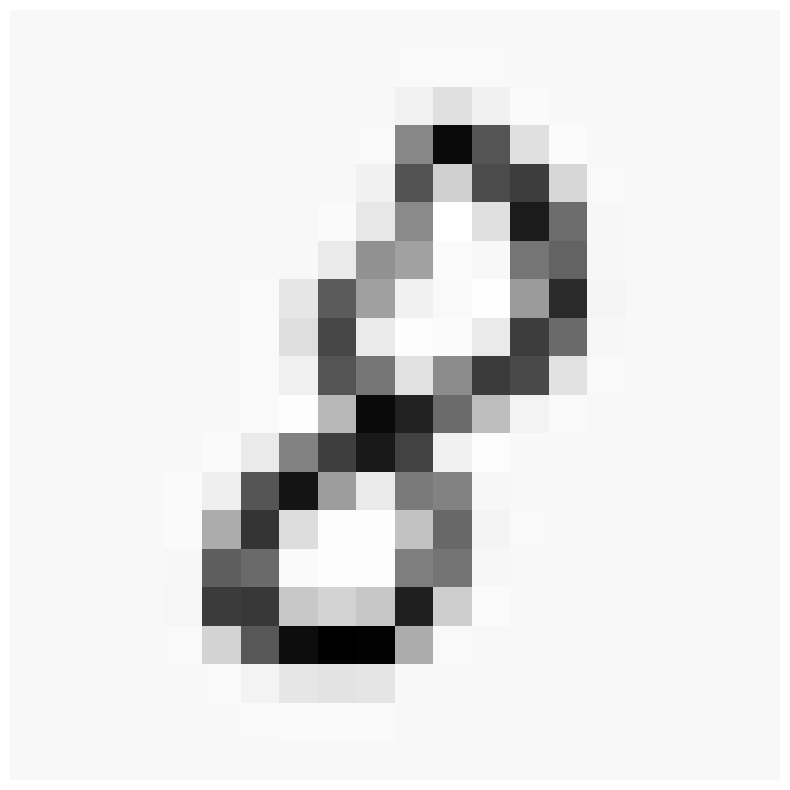

In [45]:
valor = 4267
XPrueba = X[valor:valor+1, :].copy()
print("El valor es: ", y[valor])
peso = [model.w1, model.b1, model.w2, model.b2]
prediccion = model.predict(peso, x=XPrueba)
#numero2 = definirNumero(prediccion)
print (prediccion)
#print("El numero predicho es: ", numero2)
displayData(X[valor:valor+1, :])